# Test validity step 3 : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$ becoming $P(r | ...) \propto s_c^t C(r)^{-1} s_c + ln|C(r)|$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


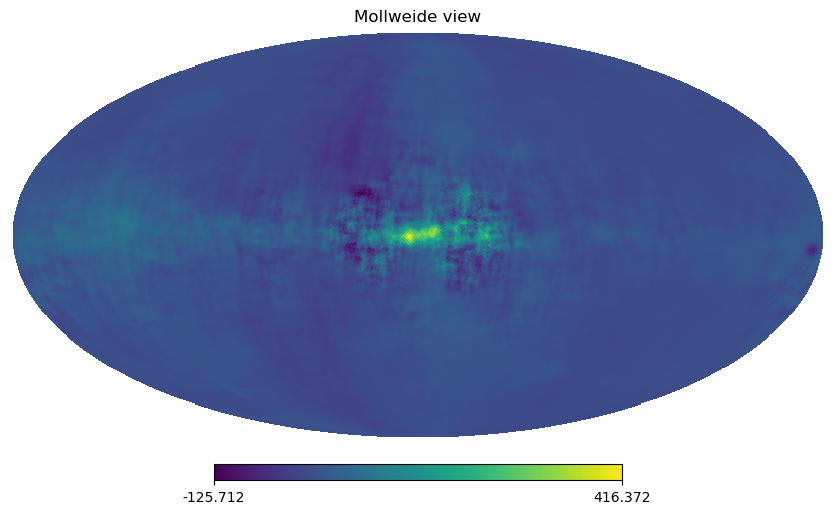

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:nstokes]

In [7]:
# input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]),input_cmb_maps[0]])
# initial_spectra = hp.anafast(input_cmb_maps_extended, lmax=lmax, iter=n_iter)
# initial_spectra[0,:] = 0
# initial_spectra[nstokes+2:,:] = 0

# c_ells_input = np.zeros((6,lmax+1))
# c_ell_approx = np.zeros((6,lmax+1))


# c_ells_input[:4,...] = initial_spectra[:4,:]
# c_ell_approx[1] = initial_spectra[1,:]
# c_ell_approx[2] = initial_spectra[2,:]

# # c_ells_input[:4,...] = camb_cls.T
# # c_ell_approx[1] = camb_cls.T[1]
# # c_ell_approx[2] = lensing_spectra.T[2]



In [8]:
all_spectra = generate_power_spectra_CAMB(nside*2, r=0, typeless_bool=True)
all_spectra_r0 = generate_power_spectra_CAMB(nside*2, r=0, typeless_bool=True)
all_spectra_r1 = generate_power_spectra_CAMB(nside*2, r=1, typeless_bool=True)
all_spectra_r2 = generate_power_spectra_CAMB(nside*2, r=.1, typeless_bool=True)


Calculating spectra from CAMB !
Calculating spectra from CAMB !
Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [9]:
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,partial_indices_polar]
tensor_spectra = all_spectra['tensor'][:lmax+1,partial_indices_polar]
lens_potential_spectra = all_spectra['lens_potential'][:lmax+1,partial_indices_polar]
camb_cls = all_spectra['total'][:lmax+1,partial_indices_polar]
unlensed_scalar_spectra = all_spectra['unlensed_scalar'][:lmax+1,partial_indices_polar]
unlensed_total_spectra = all_spectra['unlensed_total'][:lmax+1,partial_indices_polar]

lensing_spectra_r0 = all_spectra_r0['lensed_scalar'][:lmax+1,partial_indices_polar]
tensor_spectra_r0 = all_spectra_r0['tensor'][:lmax+1,partial_indices_polar]
lens_potential_spectra_r0 = all_spectra_r0['lens_potential'][:lmax+1,partial_indices_polar]
camb_cls_r0 = all_spectra_r0['total'][:lmax+1,partial_indices_polar]
unlensed_scalar_spectra_r0 = all_spectra_r0['unlensed_scalar'][:lmax+1,partial_indices_polar]
unlensed_total_spectra_r0 = all_spectra_r0['unlensed_total'][:lmax+1,partial_indices_polar]

lensing_spectra_r1 = all_spectra_r1['lensed_scalar'][:lmax+1,partial_indices_polar]
tensor_spectra_r1 = all_spectra_r1['tensor'][:lmax+1,partial_indices_polar]
lens_potential_spectra_r1 = all_spectra_r1['lens_potential'][:lmax+1,partial_indices_polar]
camb_cls_r1 = all_spectra_r1['total'][:lmax+1,partial_indices_polar]
unlensed_scalar_spectra_r1 = all_spectra_r1['unlensed_scalar'][:lmax+1,partial_indices_polar]
unlensed_total_spectra_r1 = all_spectra_r1['unlensed_total'][:lmax+1,partial_indices_polar]

lensing_spectra_r2 = all_spectra_r2['lensed_scalar'][:lmax+1,partial_indices_polar]
tensor_spectra_r2 = all_spectra_r2['tensor'][:lmax+1,partial_indices_polar]
lens_potential_spectra_r2 = all_spectra_r2['lens_potential'][:lmax+1,partial_indices_polar]
camb_cls_r2 = all_spectra_r2['total'][:lmax+1,partial_indices_polar]
unlensed_scalar_spectra_r2 = all_spectra_r2['unlensed_scalar'][:lmax+1,partial_indices_polar]
unlensed_total_spectra_r2 = all_spectra_r2['unlensed_total'][:lmax+1,partial_indices_polar]


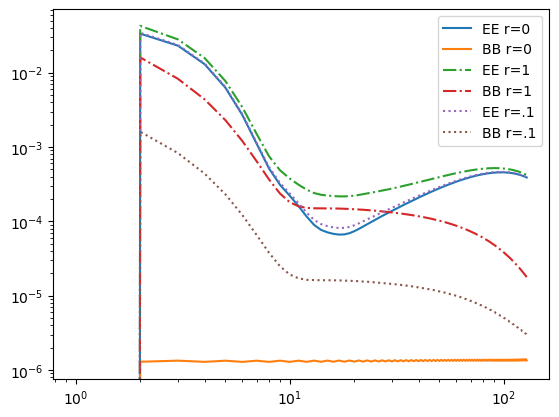

In [10]:
ell_arange = np.arange(lensing_spectra.shape[0])
plt.plot(ell_arange, camb_cls)
plt.plot(ell_arange, camb_cls_r1, '-.')
plt.plot(ell_arange, camb_cls_r2, ':')
plt.loglog()
# plt.legend(['TT','EE','BB','TE', 'TT','EE','BB','TE', 'TT','EE','BB','TE'])
plt.legend(['EE r=0','BB r=0','EE r=1','BB r=1','EE r=.1','BB r=.1'])
plt.show()

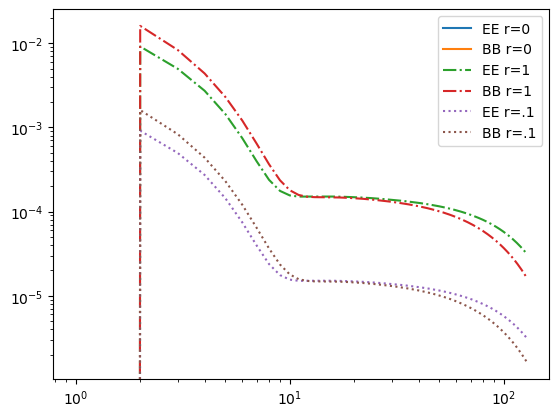

In [11]:
ell_arange = np.arange(lensing_spectra.shape[0])
plt.plot(ell_arange, tensor_spectra)
plt.plot(ell_arange, tensor_spectra_r1, '-.')
plt.plot(ell_arange, tensor_spectra_r2, ':')
plt.loglog()
plt.legend(['EE r=0','BB r=0','EE r=1','BB r=1','EE r=.1','BB r=.1'])
plt.show()

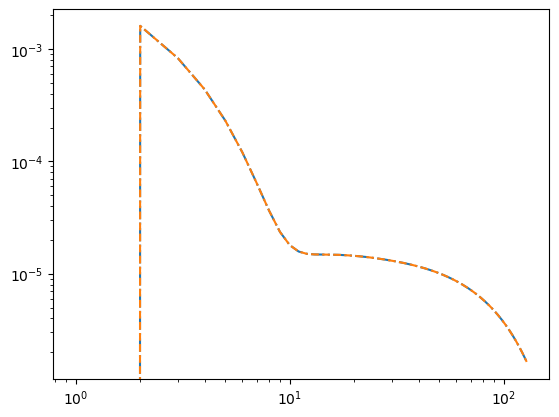

In [12]:
ell_arange = np.arange(lensing_spectra.shape[0])
plt.plot(ell_arange, tensor_spectra_r1[:,1]*.1, '-.')
plt.plot(ell_arange, tensor_spectra_r2[:,1], '--')
plt.loglog()
# plt.legend()
plt.show()

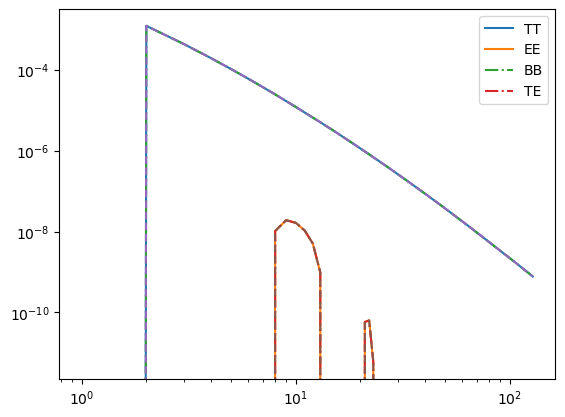

In [13]:
ell_arange = np.arange(lensing_spectra.shape[0])
plt.plot(ell_arange, lens_potential_spectra)
plt.plot(ell_arange, lens_potential_spectra_r1, '-.')
plt.plot(ell_arange, lens_potential_spectra_r2, '--')
plt.loglog()
plt.legend(['TT','EE','BB','TE'])
plt.show()

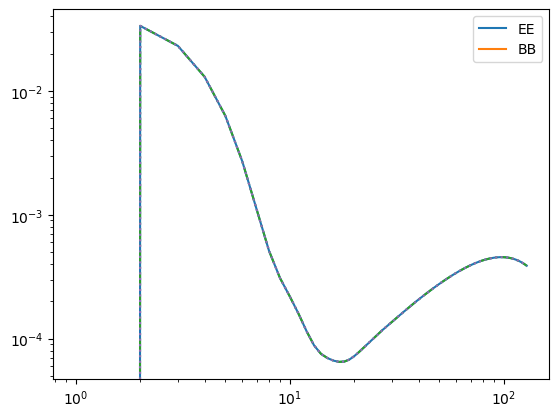

In [14]:
ell_arange = np.arange(lensing_spectra.shape[0])
plt.plot(ell_arange, unlensed_scalar_spectra)
plt.plot(ell_arange, unlensed_scalar_spectra_r1, '-.')
plt.plot(ell_arange, unlensed_scalar_spectra_r2, ':')
plt.loglog()
plt.legend(['EE','BB'])
plt.show()

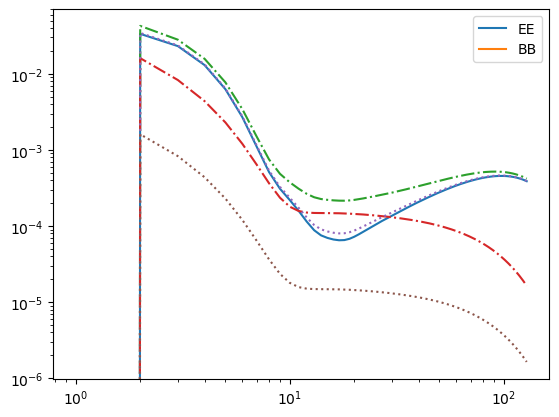

In [15]:
ell_arange = np.arange(lensing_spectra.shape[0])
plt.plot(ell_arange, unlensed_total_spectra)
plt.plot(ell_arange, unlensed_total_spectra_r1, '-.')
plt.plot(ell_arange, unlensed_total_spectra_r2, ':')
plt.loglog()
plt.legend(['EE','BB'])
plt.show()

In [16]:
# indices_polar = np.array([1,2,4])

# if nstokes == 2:    
#     c_ells_input = c_ells_input[indices_polar,:]
#     c_ell_approx = c_ell_approx[indices_polar,:]
#     # CMB_map_input = CMB_map_input[1:,:]
#     # freq_maps = freq_maps[:,1:,:]

In [17]:
depth_p = instrument['depth_p']

freq_inverse_noise = micmac.get_noise_covar(depth_p, nside)

init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[0,-1])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[0,-1])

mixing_matrix_sampled = mixing_matrix_obj.get_B()

cp_cp_noise = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [18]:
a_test = np.array([[1,0],[0,-1]])
a_array = np.repeat(a_test, 4).reshape((4,2,2),order='F')
np.linalg.det(a_array)

array([-1., -1., -1., -1.])

In [19]:
def get_conditional_proba_C_from_r(r_param, **model_kwargs):
    red_sigma_ell = model_kwargs['red_sigma_ell']

    # red_cov_matrix_sampled = model_kwargs['red_cov_matrix_sampled']
    red_cov_matrix_sampled = r_param * model_kwargs['theoretical_red_cov_r1_tensor'] + model_kwargs['theoretical_red_cov_r0_total']

    sum_dets = ( (2*jnp.arange(model_kwargs['lmin'], model_kwargs['lmax']+1) +1) * jnp.log(jnp.linalg.det(red_cov_matrix_sampled)) ).sum()
    
    return -( jnp.einsum('lij,lji->l', red_sigma_ell, jnp.linalg.pinv(red_cov_matrix_sampled)).sum() + sum_dets)/2
    # return -(jnp.einsum('lij,lji->l', red_sigma_ell, jnp.linalg.pinv(red_cov_matrix_sampled)).sum() + 0)/2
    # return -(sum_dets)/2


def get_sample_parameter(mcmc_kernel, full_initial_guess, random_PRNGKey=random.PRNGKey(100), **model_kwargs):
    
    # mcmc.run(random.PRNGKey(0), init_params=full_initial_guess, pos_special_freqs=jnp.array(mixing_matrix_obj.pos_special_freqs), full_data_without_CMB=jnp.array(full_data_without_CMB), modified_sample_eta_maps=jnp.array(modified_sample_eta_maps_v2), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)
    mcmc_kernel.run(random_PRNGKey, init_params=full_initial_guess, **model_kwargs)
    
    mcmc_kernel.print_summary()

    return mcmc_kernel.get_samples(group_by_chain=True)

In [78]:
r_true = 0.0
# r_true = 10**(-3)


theoretical_r1_tensor = np.zeros((number_correlations,lmax+1))
theoretical_r0_total = np.zeros_like(theoretical_r1_tensor)
# theoretical_r1_tensor[:nstokes,...] = tensor_spectra_r1[:,partial_indices_polar].T
# # theoretical_r0_total[:nstokes,...] = camb_cls_r0[:,partial_indices_polar].T
# theoretical_r0_total[:nstokes,...] = unlensed_scalar_spectra_r0[:,partial_indices_polar].T
theoretical_r1_tensor[:nstokes,...] = tensor_spectra_r1.T
# theoretical_r0_total[:nstokes,...] = camb_cls_r0.T
theoretical_r0_total[:nstokes,...] = unlensed_scalar_spectra_r0.T


theoretical_red_cov_r1_tensor = micmac.get_reduced_matrix_from_c_ell(theoretical_r1_tensor)[lmin:]
theoretical_red_cov_r0_total = micmac.get_reduced_matrix_from_c_ell(theoretical_r0_total)[lmin:]

true_cmb_specra = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + r_true*theoretical_red_cov_r1_tensor)
true_cmb_specra_extended = np.zeros((6,lmax+1-lmin))
true_cmb_specra_extended[indices_polar,...] = true_cmb_specra

input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=nside, new=True, lmax=lmax)[1:,...]

# input_cmb_maps = np.repeat(input_cmb_maps_alt, number_frequencies).reshape((number_frequencies,nstokes,npix),order='F')
input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), number_frequencies).reshape((number_frequencies,nstokes,npix),order='F')
# input_cmb_maps = np.tile(input_cmb_maps_alt.ravel(order='F'),number_frequencies).reshape((number_frequencies, nstokes, npix))
# input_cmb_maps = np.array([input_cmb_maps_alt for i in range(number_frequencies)])
freq_maps = input_cmb_maps + freq_maps_fgs


In [79]:
true_red_cov_cmb_specra = micmac.get_reduced_matrix_from_c_ell(true_cmb_specra)

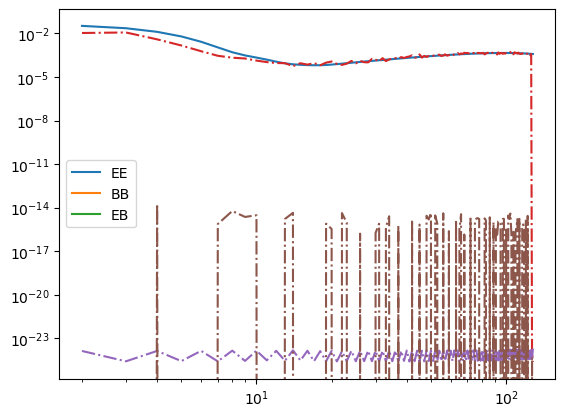

In [80]:
true_cmb_specra_extended[4,lmin:] = np.random.choice([1,-1],size=(lmax+1-2*lmin))*10**(-15)


# c_ells_anafast = hp.anafast(input_cmb_maps_alt_2, lmax=lmax, iter=20)[indices_polar,lmin:]
input_cmb_maps_alt_2 = hp.synfast(true_cmb_specra_extended, nside=nside, new=True, lmax=lmax)
c_ells_anafast = hp.anafast(input_cmb_maps_alt_2, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
# input_cmb_maps_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0]),input_cmb_maps[0]])
# c_ells_input_cmb = hp.anafast(input_cmb_maps_ext,lmax=lmax,iter=n_iter)[indices_polar,lmin:]

plt.plot(np.arange(true_cmb_specra_extended.shape[-1])+lmin,true_cmb_specra.T)
plt.plot(np.arange(c_ells_anafast.shape[-1])+lmin,c_ells_anafast.T, '-.')
# plt.plot(np.arange(true_cmb_specra_extended.shape[-1]),true_cmb_specra_extended.T)
# plt.plot(np.arange(c_ells_anafast.shape[-1]),c_ells_anafast.T, '-.')
# plt.plot(np.arange(c_ells_anafast.shape[-1]),c_ells_input_cmb.T, ':')
plt.loglog()
# plt.legend(['TT','EE','BB','TE','EB','TB'])
plt.legend(['EE','BB','EB'])
plt.show()

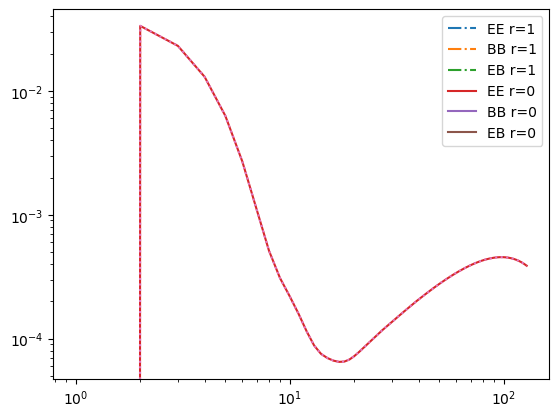

In [81]:
plt.plot(np.arange(theoretical_r1_tensor.shape[-1]),theoretical_r1_tensor.T*r_true, '-.')
plt.plot(np.arange(theoretical_r1_tensor.shape[-1]),theoretical_r0_total.T)
plt.plot(np.arange(theoretical_r1_tensor.shape[-1]), (theoretical_r0_total + r_true*theoretical_r1_tensor).T, ':')
plt.loglog()
plt.legend(['EE r=1','BB r=1','EB r=1', 'EE r=0','BB r=0','EB r=0'])
plt.show()

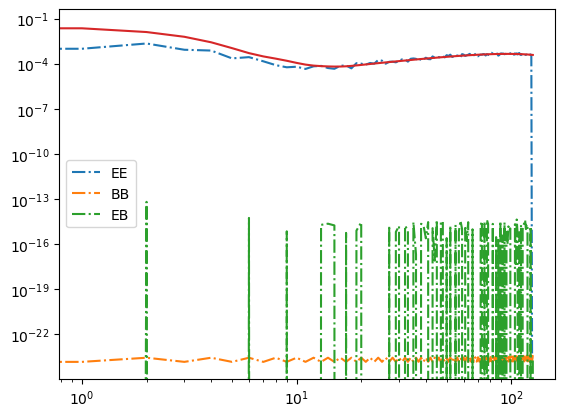

In [82]:
input_cmb_maps_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0]),input_cmb_maps[0]])

c_ells_input_cmb = hp.anafast(input_cmb_maps_ext,lmax=lmax,iter=n_iter)[indices_polar,lmin:]

plt.plot(np.arange(c_ells_input_cmb.shape[-1]),c_ells_input_cmb.T, '-.')
plt.plot(np.arange(true_cmb_specra.shape[-1]),true_cmb_specra.T)
plt.loglog()
plt.legend(['EE','BB','EB'])
plt.show()

In [83]:
s_cML = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0,...]

In [84]:
step_size_r = 10**(-4)

n_walkers = 1
num_warmup = 0
number_steps_sampler = 10000


# c_ells_Wishart = micmac.get_cell_from_map(s_c_map, lmax=lmax, n_iter=n_iter)
c_ells_Wishart = micmac.get_cell_from_map(input_cmb_maps[0], lmax=lmax, n_iter=n_iter)#[indices_polar]
c_ells_Wishart = np.zeros_like(c_ells_Wishart)
c_ells_Wishart[:,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(true_red_cov_cmb_specra)

# r_samples = np.zeros(number_steps_sampler)


kernel = micmac.MetropolisHastings_log(get_conditional_proba_C_from_r, step_size=step_size_r)
mcmc_kernel = numpyro.infer.MCMC(kernel, num_chains=n_walkers, num_warmup=num_warmup, num_samples=number_steps_sampler)

# full_initial_guess = 10**(-3)


c_ells_Wishart_modified = np.copy(c_ells_Wishart)
for i in range(nstokes):
        c_ells_Wishart_modified[i] *= 2*np.arange(lmax+1) + 1
red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell(c_ells_Wishart_modified)[lmin:]

full_initial_guess = 0.01

r_samples = get_sample_parameter(mcmc_kernel, full_initial_guess, random_PRNGKey=random.PRNGKey(100), lmin=lmin, lmax=lmax, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total)


sample: 100%|██████████| 10000/10000 [00:04<00:00, 2350.64it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      0.00      0.00      0.00      0.00      0.00     67.99      1.01



In [85]:
r_param_test_1 = 0
r_param_test_2 = 1
r_param_test_3 = 0.01
r_param_test_4 = 0.1

c_ells_Wishart_modified = np.copy(c_ells_Wishart)
for i in range(nstokes):
        c_ells_Wishart_modified[i] *= 2*np.arange(lmax+1) + 1
red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell(c_ells_Wishart_modified)[lmin:]


print(r_param_test_1, get_conditional_proba_C_from_r(r_param_test_1, red_sigma_ell=red_c_ells_Wishart_modified, lmin=lmin, lmax=lmax, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total))
print(r_param_test_2, get_conditional_proba_C_from_r(r_param_test_2, red_sigma_ell=red_c_ells_Wishart_modified, lmin=lmin, lmax=lmax, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total))
print(r_param_test_3, get_conditional_proba_C_from_r(r_param_test_3, red_sigma_ell=red_c_ells_Wishart_modified, lmin=lmin, lmax=lmax, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total))
print(r_param_test_4, get_conditional_proba_C_from_r(r_param_test_4, red_sigma_ell=red_c_ells_Wishart_modified, lmin=lmin, lmax=lmax, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total))


0 inf
1 140028.56586329333
0.01 178645.0187031792
0.1 159483.82380281817


In [91]:
log_space_r = np.logspace(-8,3, num=100)

if r_true != 0:
        log_r_true = np.log10(r_true)
        log_space_r = np.logspace(log_r_true-.1,log_r_true+.1, num=100)
else:
        log_space_r = np.logspace(-20,-2, num=100)
c_ells_Wishart_modified = np.copy(c_ells_Wishart)
for i in range(nstokes):
        c_ells_Wishart_modified[i] *= 2*np.arange(lmax+1) + 1
red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell(c_ells_Wishart_modified)[lmin:]

all_logproba_r = np.array([get_conditional_proba_C_from_r(r_logspace, red_sigma_ell=red_c_ells_Wishart_modified, lmin=lmin, lmax=lmax, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total) for r_logspace in log_space_r])

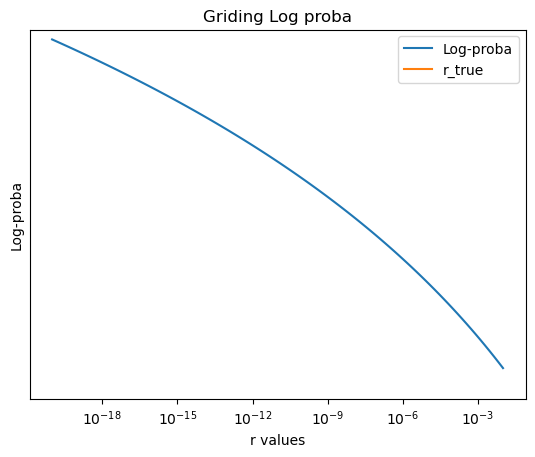

In [92]:
plt.plot(log_space_r, all_logproba_r, label='Log-proba')
plt.plot([r_true, r_true], [all_logproba_r.min(), all_logproba_r.max()], label='r_true')
# plt.plot([1/r_true, 1/r_true], [all_logproba_r.min(), all_logproba_r.max()], label='1/r_true')
# plt.plot([10**(2), 10**(2)], [all_logproba_r.min(), all_logproba_r.max()], label='10^2')
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('r values')
plt.ylabel('Log-proba')
plt.title('Griding Log proba')
# plt.ylim(ymax=all_logproba_r.max())
plt.legend()
plt.show()

In [93]:
r_samples.shape

(1, 10000)

In [94]:
red_c_ells_samples = np.zeros((number_steps_sampler, lmax+1-lmin, nstokes, nstokes))

for i in range(number_steps_sampler):
    red_c_ells_samples[i,...] = theoretical_red_cov_r0_total + r_samples[0,i]*theoretical_red_cov_r1_tensor
    


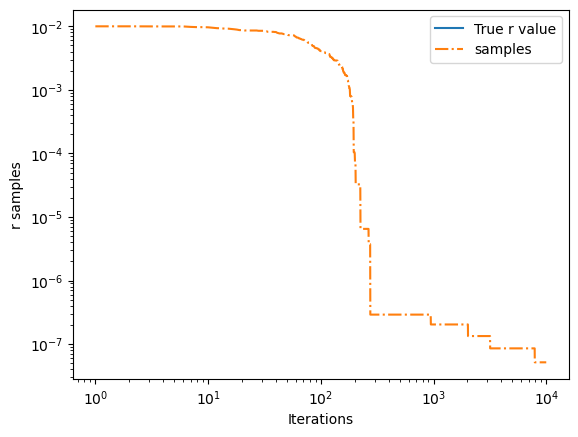

In [95]:
plt.plot([1,number_steps_sampler], [r_true,r_true], label='True r value')
plt.plot(np.arange(number_steps_sampler)+1, r_samples[0], '-.', label='samples')
plt.xlabel('Iterations')
plt.ylabel('r samples')
plt.loglog()
plt.legend()
plt.show()